# Übung 4.1 : Das Traglinienverfahren und die Prandtl'sche Tragflügeltheorie

<div style="text-align: justify"> </p>Die Übung 4 ist die erste von insgesamt fünf computer-basierten Übungen und soll einen ersten Einblick in aerodynamische Optimierungsaufgaben geben und wie sie mit Algorithmen gelöst werden können. </p>

Die **Prandtl'sche Traglinientheorie (engl. "lifting line theory")** besteht seit der Zeit des ersten Weltkrieges und findet heutzutage immernoch Anwendung. Darauf basierend wird das numerische Traglinienverfahren als analytische Methode eingesetzt, um im Flügel-Vorentwurf Vorhersagen über Effizienz und Verluste von Tragflügeln endlicher Streckung zu treffen.

#### Was liefert die Traglinientheorie?
- Auftriebsverteilung entlang der Spannweite
- Auftriebskraft 
- Induzierter Widerstand (Effizienz)

#### Was sind die Einschränkungen?
- gilt nur für große Streckungen
- Pfeilung kann nicht berücksichtigt werden 
- gilt nur für kleine Anstellwinkel

Die ausführliche Theorie zum Verfahren findet ihr in den Skripten begleitend zur Vorlesung. Nachfolgend soll nun exemplarisch gezeigt werden, wie ein solches Traglinienverfahren in Python implementiert werden kann
 </div>

In [12]:
# Importieren von Python-Biblioteken
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider, FloatSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets

# Fügt das parent diretory zum Python-Pfad hinzu, damit Dateien aus anderen Directories gelesen werden können
sys.path.append(os.path.abspath(os.path.join('..')))

## Aufgabe 4.1 a)
Untersuchen Sie am Beispiel des Rechteckflügels mit $l_i=1$ und $\Lambda = 10$ das Konvergenzverhalten der aerodynamischen Beiwerte ($C_W$, $C_A$) und des Oswald Faktors hinsichtlich der Abhängigkeit von der Anzahl der Elementarflügel (räumliche Diskretisierung).
Entscheiden Sie sich für eine Diskretisierung für alle folgenden Aufgabenteil und begründen Sie diese Entscheidung.

### 4.1.1 Visualisierung: Doppeltrapezflügel

In [13]:
def doppeltrapezfluegel(l_a, l_k, AR, l_i=1.0) -> np.array:
    """
    Generiert die Planform eines Doppeltrapezflügels in Form von Eckpunkten auf Basis der gegebenen 
    Flügeltiefen und der Streckung.

    Args:
        l_a (float): Flügeltiefe außen
        l_k (float): Flügeltiefe Kink
        AR (float): Streckung
        l_i (float, optional): Flügeltiefe innen. Defaults to 1.0.

    Returns:
        np.array: Array aus Flügeleckpunkten zum plotten
    """
    # Berechnung der Halbspannweite
    b = AR * (l_k*0.75 + 0.5*(l_i-l_k)*0.75+l_a*(1-0.75)+0.5*(l_k-l_a)*0.25)
    s = b / 2

    # Berechnung der Kink-Position (bei 75% der Halbspannweite)
    y_lk = 0.75 * s 

    # Definition dller Eckpunkte
    points = np.array([
        [0, l_i/2],              
        [y_lk, l_k/2],    
        [s, l_a/2],         
        [s, -l_a/2],         
        [y_lk, -l_k/2],         
        [0, -l_i/2],
        [-y_lk, -l_k/2],  
        [-s, -l_a/2],    
        [-s, l_a/2] ,         
        [-y_lk, l_k/2],
        [0, l_i/2]
    ])
    
    return points

def plot_doppeltrapezfluegel(l_a, l_k, AR):
    # Flügeleckpunkte generieren
    points = doppeltrapezfluegel(l_a, l_k, AR)

    # Geometrie plotten
    plt.figure(figsize=(10, 6))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, -0.5, 0.5, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Doppeltrapezflügel')
    plt.axis('equal')
    plt.show()

def widget_doppeltrapezfluegel():
    # Slider
    slider_l_k = VBox([Label('Flügeltiefe Kink'), FloatSlider(value=0.8, min=0, max=1.0, step=0.1)])
    slider_l_a = VBox([Label('Flügeltiefe außen'), FloatSlider(value=0.5, min=0, max=1.0, step=0.1)])
    slider_AR = VBox([Label('Streckung'), FloatSlider(value=10, min=5, max=20, step=1)])

    # Interaktiver plot
    ui = VBox([slider_l_k, slider_l_a, slider_AR])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_doppeltrapezfluegel, {'l_a': slider_l_a.children[1], 'l_k': slider_l_k.children[1], 'AR': slider_AR.children[1]})

    return HBox([out, ui])

In [14]:
display(widget_doppeltrapezfluegel())

### 4.1.2 Geometrische Parameter und Randbedinungen

In [15]:
# Konstant
alpha = 0.5               # Anstellwinel [rad]

# alpha in grad angeben, dann umrechnung in rad
U_inf = 10.0            # Anströmgeschwindigkeit [m/s]
rho = 1.225             # Dichte [kg/m^3]
l_i = 1.0               # Flügeltiefe Wurzel [m]

#### EINGABE

In [16]:
l_a = 0.3               # Flügeltiefe außen [m]
l_k = 0.8               # Flügeltiefe kink [m]
AR = 20                 # Streckung/ Aspect Ratio

#### Berechnung weiterer geometrischer Parameter

In [17]:
# Berechnung der Halbspannweite
b = AR * (l_k*0.75 + 0.5*(l_i-l_k)*0.75+l_a*(1-0.75)+0.5*(l_k-l_a)*0.25)   
s = b / 2 

# Berechnung der Kink-Position (bei 75% der Halbspannweite)
y_lk = 0.75 * s     

# Berechnung der Flügelfläche aus Halbspannweite und Streckung
S = b**2 / AR         

# Ausgabe
print("Spannweite:                  ", "%.2f" % b, "m")
print("Halbspannweite:              ", "%.2f" % s, "m")
print("Kink-Position:               ", "%.2f" % y_lk, "m")
print("Flügelfläche:                ", "%.2f" % S, "m^2")

Spannweite:                   16.25 m
Halbspannweite:               8.12 m
Kink-Position:                6.09 m
Flügelfläche:                 13.20 m^2


#### Vergleich mit elliptischer Planform (bei gleicher Halbspannweite?)

In [18]:
h_ell = l_i/2 * (np.sqrt(1 - (y_lk / s)**2))                                # ???                   
S_ell = np.pi * l_i * 0.5 * s                                               # entsprechende Fläche
AR_ell = b**2 / S_ell                                                       # entsprechende Streckung

# Ausgabe
print("???:                         ", "%.2f" % h_ell, "m")
print("Flügelfläche:                ", "%.2f" % S_ell, "m^2")
print("Streckung:                   ", "%.2f" % AR_ell)

???:                          0.33 m
Flügelfläche:                 12.76 m^2
Streckung:                    20.69


### 4.1.4 Berechnung der Hufeisenwirbel-Koordinaten

Zur Bestimmung der $N$ (Variable n) unbekannten Wirbelstärken $\Gamma$ wird die kinematische Strömungsbedingung in den $N$ (Variable $m$) Aufpunkten erfüllt, und man hat ein lineares Gleichungssystem zu lösen. Dafür werden die Koordinaten des tragenden Wirbels entlang der örtlichen $l_p/4$-Linie (indizes a, b) am Rand jedes Elementarflügels sowie die der Aufpunkte im $3l_p/4$–Punkt des Mittelschnittes jedes Elementarflügels (index c) bestimmt.

In [19]:
def tiefe_doppeltrapez(y, y_lk, l_k, l_a, s) -> float:
    """Berechnet mit gegebenen Geometriepartametern eines Doppeltrapezflügels die lokale Flügeltiefe für eine spannweitige Position

    Args:
        y (float): spannweitige Position
        y_lk (float): spannweitige Kink-Position
        l_k (float): Flügeltiefe Kink
        l_a (float): Flügeltiefe außen
        s (float): Halbspannweite

    Returns:
        float: lokale Flügeltiefe
    """
    y = abs(y)
    if y <= y_lk:
        return 1 + (l_k - 1) * (y / y_lk)
    else:
        return l_k + (l_a - l_k) * ((y - y_lk) / (s - y_lk))
    
def plot_diskretisierung_doppeltrapez(l_a, l_k, y_lk, AR, s, N):
    points = doppeltrapezfluegel(l_a, l_k, AR)
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    
    chord_values = [tiefe_doppeltrapez(y, y_lk, l_k, l_a, s) for y in y_values]
    
    # Geometrie plotten
    plt.figure(figsize=(10, 6))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Elementarflügel plotten
    for i in range(N):
        plt.plot([y_values[i], y_values[i]], [-chord_values[i]/2, chord_values[i]/2], 'g-')
    
    plt.vlines(0, -0.5, 0.5, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Doppeltrapezflügel')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def widget_diskretisierung_doppeltrapez(l_a, l_k, y_lk, AR, s):
    # Slider
    slider_N = VBox([Label('Anzahl der Elementarflügel'), IntSlider(value=30, min=1, max=100, step=1)])

    # Interaktiver plot
    ui = VBox([slider_N])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_doppeltrapez, {'l_a': fixed(l_a), 'l_k': fixed(l_k), "y_lk": fixed(y_lk), 'AR': fixed(AR), "s": fixed(s), 'N': slider_N.children[1]})
    return HBox([out, ui])

In [20]:
# Visualisierung der Diskretisierung
display(widget_diskretisierung_doppeltrapez(l_a, l_k, y_lk, AR, s))

#### EINGABE

In [21]:
# # Anzahl der Elementarflügel und Breite eines Elementarflügels
N = 200               
delta_b = b/N                  

In [22]:
# Spannweitige Positionen der Punkte A, B und Aufpunkt C
y_a = np.array([-s +  j    * delta_b for j in range(N)])
y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

# Tiefenposition der Punkte A und B und Aufpunkt C
def x_position(y, l_i, l_k, l_a, y_lk, aufpunkt=False):
    tiefe = 0.75 if aufpunkt else 0.25
    if abs(y) <= y_lk:
        return (abs(y)/y_lk * 0.5*(l_i-l_k) + tiefe*(l_i - abs(y)/y_lk * (l_i-l_k)))
    else:
        return (0.5*(l_i-l_k) + (abs(y)-y_lk)/(s-y_lk) * 0.5*(l_k-l_a) + tiefe*(l_k - (abs(y)-y_lk)/(s-y_lk)*(l_k-l_a)))
    
x_a = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_a])
x_b = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_b])
x_c = np.array([x_position(y_i, l_i, l_k, l_a, y_lk, True) for y_i in y_c])

# Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

# Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
x_aoo = x_a + 100*s
x_boo = x_b + 100*s

In [23]:
print("Punkt A:     :", y_a[0], x_a[0])
print("Punkt Aoo    :", y_aoo[0], x_aoo[0])
print("Punkt C:     :", y_c[0], x_c[0])
print("Punkt B:     :", y_b[0], x_b[0])
print("Punkt Boo    :", y_boo[0], x_boo[0])

Punkt A:     : -8.125 0.425
Punkt Aoo    : -8.125 812.925
Punkt C:     : -8.084375 0.5775000000000001
Punkt B:     : -8.04375 0.41999999999999993
Punkt Boo    : -8.04375 812.92


### 4.1.5 Berechnung der Koeffizientenmatrix

In [24]:
# initialisieren der Matrizen
a_AB = np.zeros((x_a.size, x_a.size))
a_Aoo = np.zeros((x_a.size, x_a.size))
a_Boo = np.zeros((x_a.size, x_a.size))

for j in range(N):
    for i in range(N):
        a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

for j in range(N):
    for i in range(N):
        a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

for j in range(N):
    for i in range(N):
        a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

In [25]:
a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

# die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B

### 4.1.6 Berechnung von Kräften und Beiwerten

In [26]:
# Berechnung des Auftriebs nach Kutta-Joukowsky
A_j = rho * delta_b * U_inf * Gamma
A = np.sum(A_j)

# Berechnung des induzierten Widerstands
w_m = a_ind * Gamma
W_ind = np.sum(-rho *w_m @ Gamma * delta_b)

print("Auftrieb:                    ", "%.2f" % A, "N")
print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")

Auftrieb:                     2273.71 N
Induzierter Widerstand:       104.35 N


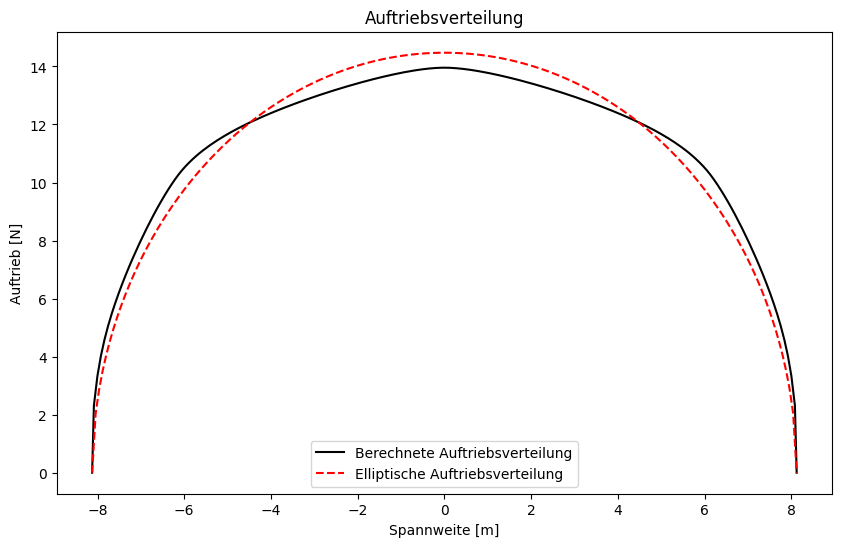

In [27]:
# Auftriebsverteilung plotten

# Erweitere A_distr und y_c am Anfang und Ende um an den tips auf 0 zu plotten
A_j = np.insert(A_j, 0, 0)
A_j = np.append(A_j, 0)
y_c = np.insert(y_c, 0, -s)
y_c = np.append(y_c, s)

# Berechne die Fläche unter der berechneten Auftriebsverteilung
area_distr = np.trapz(A_j, y_c)

# Erzeuge die elliptische Auftriebsverteilung
y_elliptisch = np.linspace(-s, s, len(y_c))
A_elliptisch_raw = np.sqrt(1 - (y_elliptisch / s) ** 2)

# Skaliere die elliptische Verteilung so, dass die Flächen gleich sind
area_elliptisch_raw = np.trapz(A_elliptisch_raw, y_elliptisch)
scale_factor = area_distr / area_elliptisch_raw
A_elliptisch = A_elliptisch_raw * scale_factor

# Plotten der Auftriebsverteilungen
plt.figure(figsize=(10, 6))
plt.plot(y_c, A_j, '-', color="black", label='Berechnete Auftriebsverteilung')
plt.plot(y_elliptisch, A_elliptisch, '--', color="red", label='Elliptische Auftriebsverteilung')
plt.xlabel('Spannweite [m]')
plt.ylabel('Auftrieb [N]')
plt.title('Auftriebsverteilung')
plt.legend()
plt.show()

In [28]:
# Auftriebsbeiwert
C_A = 2*A / (rho * U_inf**2 * S)

# Widerstandsbeiwert (induziert)
C_W_ind = 2*W_ind / (rho * U_inf**2 * S)

print("Auftriebsbeiwert:            ", "%.5f" % C_A)
print("Widerstandsbeiwert:          ", "%.5f" % C_W_ind)

Auftriebsbeiwert:             2.81159
Widerstandsbeiwert:           0.12904


In [29]:
# Induzierter Widerstand der elliptischen Zirkulationsverteilung
C_W_ind_ell = C_A**2 / AR / np.pi

# Oswald Faktor
Oswald = C_W_ind_ell / C_W_ind

print("Widerstandsbeiwert (Ellipse):", "%.5f" % C_W_ind_ell)
print("Oswald-Faktor:               ", "%.2f" % Oswald)

Widerstandsbeiwert (Ellipse): 0.12581
Oswald-Faktor:                0.97


## Konvergenzstudie 1a)

In [30]:
N_study = [10, 15, 25, 50, 100, 200, 500, 750, 1000]
C_A, C_W_ind, Oswald = [], [], []

for c, N in enumerate(N_study):
    delta_b = b/N
    
    # Spannweitige Positionen der Punkte A, B und Aufpunkt C
    y_a = np.array([-s +  j    * delta_b for j in range(N)])
    y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
    y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

    # Tiefenposition der Punkte A und B und Aufpunkt C
    def x_position(y, l_i, l_k, l_a, y_lk, aufpunkt=False):
        tiefe = 0.75 if aufpunkt else 0.25
        if abs(y) <= y_lk:
            return (abs(y)/y_lk * 0.5*(l_i-l_k) + tiefe*(l_i - abs(y)/y_lk * (l_i-l_k)))
        else:
            return (0.5*(l_i-l_k) + (abs(y)-y_lk)/(s-y_lk) * 0.5*(l_k-l_a) + tiefe*(l_k - (abs(y)-y_lk)/(s-y_lk)*(l_k-l_a)))
        
    x_a = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_a])
    x_b = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_b])
    x_c = np.array([x_position(y_i, l_i, l_k, l_a, y_lk, True) for y_i in y_c])

    # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
    y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
    y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

    # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
    x_aoo = x_a + 100*s
    x_boo = x_b + 100*s

    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    for j in range(N):
        for i in range(N):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    for j in range(N):
        for i in range(N):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    for j in range(N):
        for i in range(N):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

    a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
    a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
    alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

    # die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
    Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B

    # Berechnung des Auftriebs nach Kutta-Joukowsky
    A_j = rho * delta_b * U_inf * Gamma
    A = np.sum(A_j)

    # Berechnung des induzierten Widerstands
    w_ind = a_ind * Gamma
    W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

    # Auftriebsbeiwert
    C_A.append(2*A / (rho * U_inf**2 * S))

    # Widerstandsbeiwert (induziert)
    C_W_ind.append(2*W_ind / (rho * U_inf**2 * S))

    # Induzierter Widerstand der elliptischen Zirkulationsverteilung
    C_W_ind_ell = C_A[c]**2 / AR / np.pi

    # Oswald Faktor
    Oswald.append(C_W_ind_ell / C_W_ind[c])

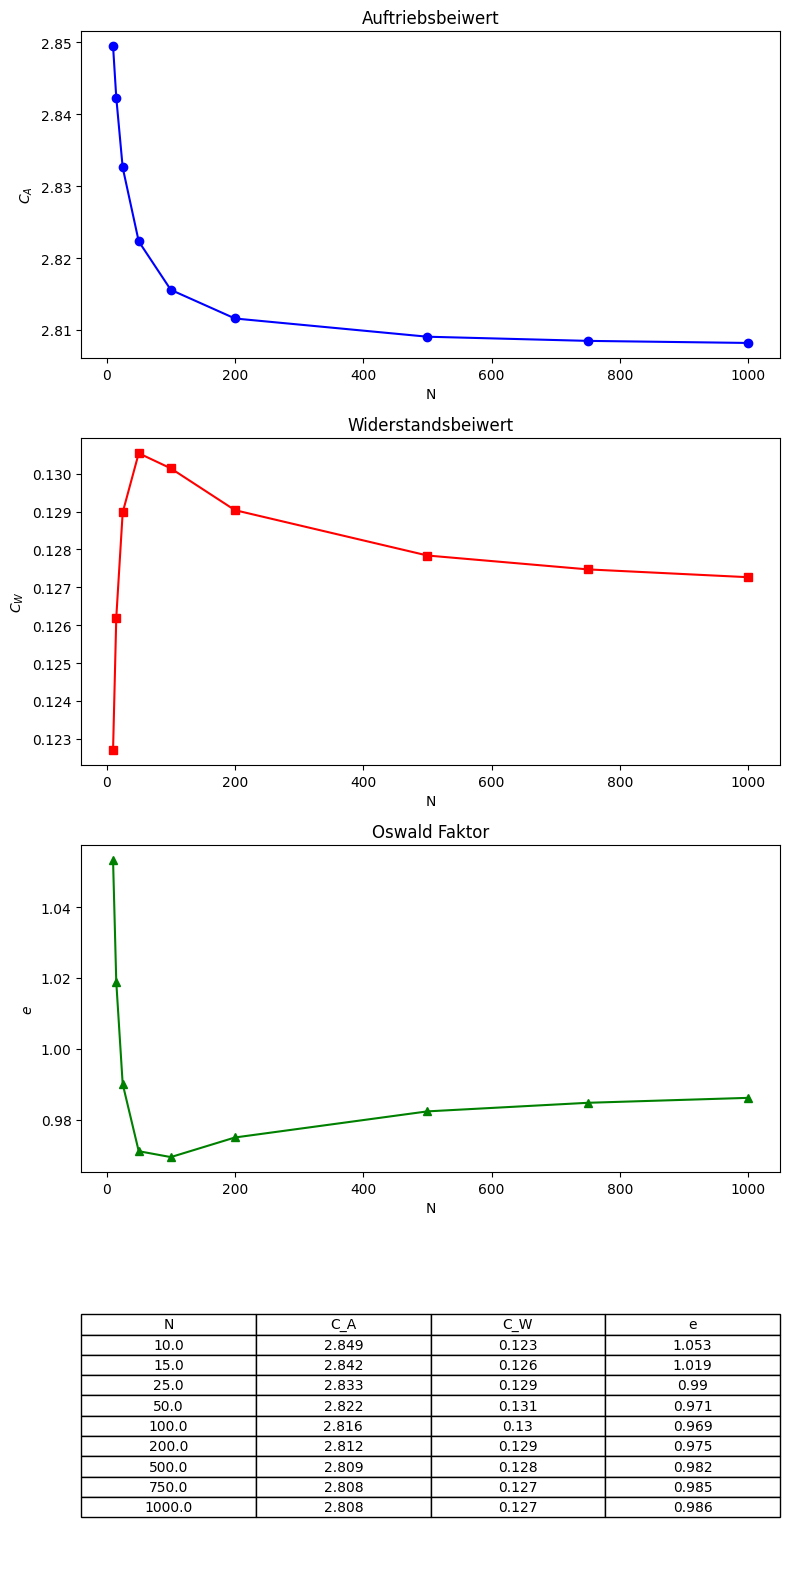

In [31]:
# Erstelle ein DataFrame
data = {
    'N': N_study,
    'C_A': [round(num, 3) for num in C_A],
    'C_W': [round(num, 3) for num in C_W_ind],
    'e': [round(num, 3) for num in Oswald]
}
df = pd.DataFrame(data)

# Erstelle die Subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

# Plot für C_A
axs[0].plot(N_study, C_A, marker='o', linestyle='-', color='b')
axs[0].set_xlabel(r"N")
axs[0].set_ylabel(r'$C_A$')
axs[0].set_title("Auftriebsbeiwert")

# Plot für C_W_ind
axs[1].plot(N_study, C_W_ind, marker='s', linestyle='-', color='r')
axs[1].set_xlabel(r"N")
axs[1].set_ylabel(r'$C_W$')
axs[1].set_title("Widerstandsbeiwert")

# Plot für Oswald
axs[2].plot(N_study, Oswald, marker='^', linestyle='-', color='g')
axs[2].set_xlabel(r"N")
axs[2].set_ylabel(r'$e$')
axs[2].set_title("Oswald Faktor")

# Erstelle die Tabelle
axs[3].axis('tight')
axs[3].axis('off')
table = axs[3].table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Automatisches Layout anpassen
plt.tight_layout()

# Zeige die Plots an
plt.show()

## Optimierung Doppeltrapezflügel 1c)

Einfluss der Flügeltiefenverteilung $\lambda = l_k/l_i$ beim Doppeltrapezflügel 

In [32]:
print(s)

8.125


In [33]:
l_k_study = np.linspace(0.2, 1, 20)

N = 500
delta_b = b/N
Oswald = []

for c, l_k in enumerate(l_k_study): 
    # Spannweitige Positionen der Punkte A, B und Aufpunkt C
    y_a = np.array([-s +  j    * delta_b for j in range(N)])
    y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
    y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])

    # Tiefenposition der Punkte A und B und Aufpunkt C
    def x_position(y, l_i, l_k, l_a, y_lk, aufpunkt=False):
        tiefe = 0.75 if aufpunkt else 0.25
        if abs(y) <= y_lk:
            return (abs(y)/y_lk * 0.5*(l_i-l_k) + tiefe*(l_i - abs(y)/y_lk * (l_i-l_k)))
        else:
            return (0.5*(l_i-l_k) + (abs(y)-y_lk)/(s-y_lk) * 0.5*(l_k-l_a) + tiefe*(l_k - (abs(y)-y_lk)/(s-y_lk)*(l_k-l_a)))
        
    x_a = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_a])
    x_b = np.array([x_position(y_i, l_i, l_k, l_a, y_lk) for y_i in y_b])
    x_c = np.array([x_position(y_i, l_i, l_k, l_a, y_lk, True) for y_i in y_c])

    # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
    y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
    y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

    # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
    x_aoo = x_a + 100*s
    x_boo = x_b + 100*s

    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    for j in range(N):
        for i in range(N):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    for j in range(N):
        for i in range(N):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    for j in range(N):
        for i in range(N):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)

    a = a_AB + a_Aoo - a_Boo                # Koeffizientenmatrix
    a_ind = a_Aoo - a_Boo                   # Koeffizientenmatrix der induzierenden Wirbel
    alpha_g = np.full((x_a.size), alpha)    # Anstellwinkelvektor

    # die Wirbelstärken werden aus Inverser der Koeffizientenmatrix, Anstellwinkelvektor und Anströmgeschwindigkeit berechnet
    Gamma = np.linalg.solve(a, alpha_g * (- U_inf)) # löst Ax = B, wobei x=Gamma

    # Berechnung des Auftriebs nach Kutta-Joukowsky
    A_j = rho * delta_b * U_inf * Gamma
    A = np.sum(A_j)

    # Berechnung des induzierten Widerstands
    w_ind = a_ind * Gamma
    W_ind = np.sum(-rho *w_ind @ Gamma * delta_b)

    # Auftriebsbeiwert
    C_A = 2*A / (rho * U_inf**2 * S)

    # Widerstandsbeiwert (induziert)
    C_W_ind = 2*W_ind / (rho * U_inf**2 * S)

    # Induzierter Widerstand der elliptischen Zirkulationsverteilung
    C_W_ind_ell = C_A**2 / AR / np.pi

    # Oswald Faktor
    Oswald.append(C_W_ind_ell / C_W_ind)

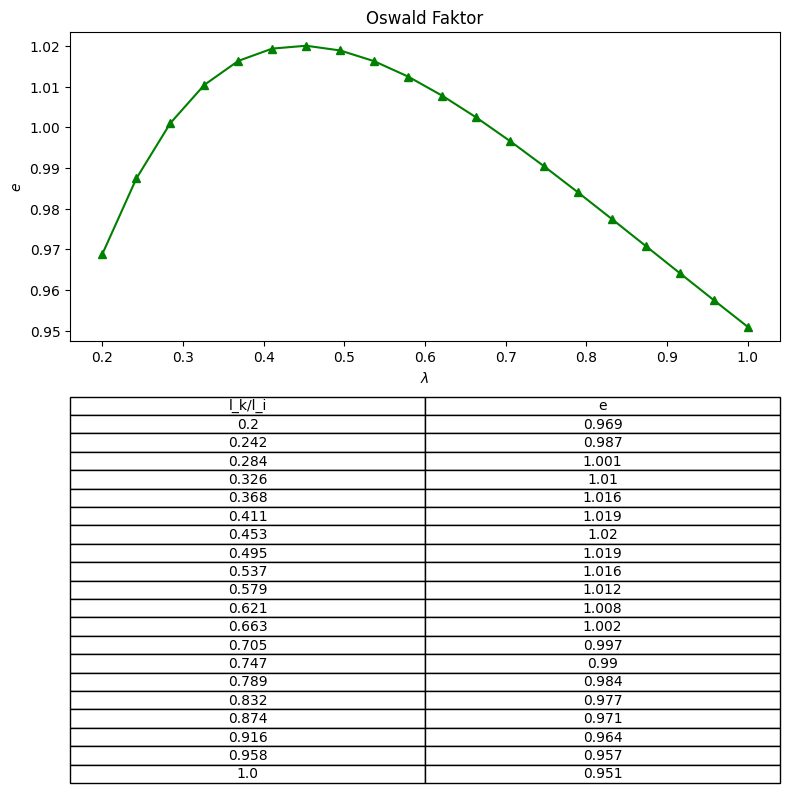

In [34]:
# Erstelle ein DataFrame
data = {
    'l_k/l_i': [round(num, 3) for num in l_k_study],
    'e': [round(num, 3) for num in Oswald]
}
df = pd.DataFrame(data)

# Erstelle die Subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot für Oswald
axs[0].plot(l_k_study, Oswald, marker='^', linestyle='-', color='g')
axs[0].set_xlabel(r"$\lambda$")
axs[0].set_ylabel(r'$e$')
axs[0].set_title("Oswald Faktor")

# Erstelle die Tabelle
axs[1].axis('tight')
axs[1].axis('off')
table = axs[1].table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

plt.tight_layout()
plt.show()